In [1]:
# Load all dictionaries
#%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf


##if you are the local
os.chdir('C:\\Users\\David\\Dropbox\\IDIBAPS\\Distractor_neurons\\FR_trials') #David_all_cond

## if your are in the cluster
#os.chdir('/home/david/Desktop/IDIBAPS/Gottlib/FR_trials')



##Load the data
### Target
LIP_control = np.load('control_LIP.npy')
LIP_0 = np.load('0_LIP.npy')
LIP_100 = np.load('100_LIP.npy')
LIP_200 = np.load('200_LIP.npy')
LIP_800 = np.load('800_LIP.npy')
####
DLPFC_control = np.load('control_DLPFC.npy')
DLPFC_0 = np.load('0_DLPFC.npy')
DLPFC_100 = np.load('100_DLPFC.npy')
DLPFC_200 = np.load('200_DLPFC.npy')
DLPFC_800 = np.load('800_DLPFC.npy')

### Distractor
LIP_control_d = np.load('control_LIP_d.npy')
LIP_0_d = np.load('0_LIP_d.npy')
LIP_100_d = np.load('100_LIP_d.npy')
LIP_200_d = np.load('200_LIP_d.npy')
LIP_800_d = np.load('800_LIP_d.npy')
####
DLPFC_control_d = np.load('control_DLPFC_d.npy')
DLPFC_0_d = np.load('0_DLPFC_d.npy')
DLPFC_100_d = np.load('100_DLPFC_d.npy')
DLPFC_200_d = np.load('200_DLPFC_d.npy')
DLPFC_800_d = np.load('800_DLPFC_d.npy')

### Response
LIP_control_r = np.load('control_LIP_r.npy')
LIP_0_r = np.load('0_LIP_r.npy')
LIP_100_r = np.load('100_LIP_r.npy')
LIP_200_r = np.load('200_LIP_r.npy')
LIP_800_r = np.load('800_LIP_r.npy')
####
DLPFC_control_r = np.load('control_DLPFC_r.npy')
DLPFC_0_r = np.load('0_DLPFC_r.npy')
DLPFC_100_r = np.load('100_DLPFC_r.npy')
DLPFC_200_r = np.load('200_DLPFC_r.npy')
DLPFC_800_r = np.load('800_DLPFC_r.npy')

In [2]:
def circdist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)



def decoding_spikes_angles_err(df, size_test=0.1):
    #### Input : dataframe with three columns: (spikes, behaviour and neuron label)
    ###Take off nans
    df = df.loc[df.iloc[:,0]<9999]
    df.columns=['spikes', 'beh', 'neuron']
    neuron_means=[]
    ### Train and test on the same neuron --> append the error of each neuron
    pop_err=[]
    
    for Neur in df.neuron.unique():
        ### same neuron 5 times --> mean value
        neur_err=[]
        for rep in range(0,5):
            spikes_train, spikes_test, beh_train, beh_test = train_test_split(df.groupby('neuron').get_group(Neur)['spikes'],
                                                                              df.groupby('neuron').get_group(Neur)['beh'],
                                                                              test_size=size_test)  

            ######## Trainning #########
            ## X matrix (intercept and spikes)
            X = np.column_stack([np.ones(np.shape(spikes_train)[0]),spikes_train])
            ## Y (sinus and cos)
            sinus =np.sin([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
            cosinus = np.cos([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
            Y = np.column_stack([cosinus, sinus])
            ### one OLS for sin and cos: output: beta of intercetp and bea of spikes (two B intercepts and 2 B for spikes )
            Y = Y.astype(float) #to make it work in the cluster
            X = X.astype(float)
            model = sm.OLS(Y, X)
            ##train the model
            fit=model.fit()

            ######### Testing ###########
            X = np.column_stack([np.ones(np.shape(spikes_test)[0]),spikes_test])
            p = fit.predict(X)
            x = p[:,0]
            y = p[:,1]
            #####
            ##### Error --> take the resulting vector in sin/cos space
            ### from sin and cos get the angle (-pi, pi)
            #pred_angle = [ np.degrees(np.arctan2(y[i], x[i]) + np.pi) for i in range(0, len(y))]
            pred_angle = [ np.degrees(np.arctan2(y[i], x[i])) for i in range(0, len(y))]
            for i in range(0, len(pred_angle)):
                if pred_angle[i]<0:
                    pred_angle[i]=360+pred_angle[i]
            ##
            #error=[ circdist(beh_test[i], pred_angle[i]) for i in range(0, len(pred_angle))]
            error=[ circdist(beh_test.values[i], pred_angle[i]) for i in range(0, len(pred_angle))]
            
            #low_value --> predicted positionns close to real
            neur_err.append(np.mean(error))
            ####
        
        #####       
        pop_err.append(np.mean(neur_err))
        ####
    
    return pop_err






In [ ]:
Conditions_titles = ['LIP_0', 'LIP_100', 'LIP_200', 'LIP_800', 'DLPFC_0', 'DLPFC_100', 'DLPFC_200', 'DLPFC_800']
Conditions = [LIP_0, LIP_100, LIP_200, LIP_800, DLPFC_0, DLPFC_100, DLPFC_200, DLPFC_800]


lens_max=[]
for cond in range(0,8):
    shuff=pd.DataFrame(Conditions[cond])
    lens_max.append(max([len(shuff.groupby(23).get_group(n)) for n in shuff[23].unique()]))

#
max_l = max(lens_max)

conditions_shuff=[]
times_shuff=[[] for N in range(0, max_l)]

for cond in range(0,8): #8  
    for N in range(0, max_l): #max_l
        print('t', cond, N)
        shuff=pd.DataFrame(Conditions[cond])
        a = np.roll(shuff[0].values, N+1)
        shuff[0]=a
        for time in range(1, 23): #(1,23)             
            df = shuff[[time, 0, 23]]
            times_shuff[N].append(decoding_spikes_angles_err(df))
    
    ##
    conditions_shuff.append(times_shuff)
    
    
####        
os.chdir('/home/david/Desktop/IDIBAPS/Gottlib/Shuffle')
np.save('Shuffle_each_conditions', np.array(conditions_shuff))


In [ ]:

# Conditions_titles = ['LIP_0_d', 'LIP_100_d', 'LIP_200_d', 'LIP_800_d', 'DLPFC_0_d', 'DLPFC_100_d', 'DLPFC_200_d', 'DLPFC_800_d']
# Conditions = [LIP_0_d, LIP_100_d, LIP_200_d, LIP_800_d, DLPFC_0_d, DLPFC_100_d, DLPFC_200_d, DLPFC_800_d]


# lens_max=[]
# for cond in range(0,8):
#     shuff=pd.DataFrame(Conditions[cond])
#     lens_max.append(max([len(shuff.groupby(23).get_group(n)) for n in shuff[23].unique()]))

# #
# max_l = max(lens_max)

# conditions_shuff=[]
# times_shuff=[[] for N in range(0, max_l)]

# for cond in range(0,8):  #8 
#     for N in range(0, max_l): #max_l
#         print('d', cond, N)
#         shuff=pd.DataFrame(Conditions[cond])
#         a = np.roll(shuff[0].values, N+1)
#         shuff[0]=a
#         for time in range(1, 23): #(1,23)             
#             df = shuff[[time, 0, 23]]
#             times_shuff[N].append(decoding_spikes_angles_err(df))
    
#     ##
#     conditions_shuff.append(times_shuff)
    


# ####        
# os.chdir('/home/david/Desktop/IDIBAPS/Gottlib/Shuffle')
# np.save('Shuffle_each_conditions_d', np.array(conditions_shuff))

In [11]:
print(np.shape(conditions_shuff))
print(np.shape(conditions_shuff[0][0]))


(8, 100, 22)

## Load the shuffle

In [10]:
os.chdir('C:\\Users\\David\\Dropbox\\IDIBAPS\\Distractor_neurons\\Shuffle')
shuffle_conditions = np.load('Shuffle_each_conditions.npy', encoding = 'latin1')
np.shape(shuffle_conditions[0])

sh_cond=1
time=100 ## 22*8
neuron =23 
np.shape(shuffle_conditions[sh_cond, time][neuron])
np.shape(shuffle_conditions[sh_cond, time])

## Amount of neuorn in first 4 and 2nd 4 conditions (IPS, DLPFC)
amount_neurons = np.unique([np.shape(shuffle_conditions[sh_cond, time])[0] for time in range(0, 176)])

shuffle_conditions = shuffle_conditions[0]


#### For each condition I have the (285, 22) matrix of each neuron
ns_IPS_0={}
ns_IPS_100={}
ns_IPS_200={}
ns_IPS_800={}
ns_DLPFC_0={}
ns_DLPFC_100={}
ns_DLPFC_200={}
ns_DLPFC_800={}

conditions_dictionaries= [ns_IPS_0, ns_IPS_100,ns_IPS_200, ns_IPS_800, ns_DLPFC_0, ns_DLPFC_100, ns_DLPFC_200, ns_DLPFC_800]
neurons_cons = [44, 44, 44, 44, 63, 63, 63, 63]
start_conditions = list(np.arange(0, 176, 22))
end_conditions = list(np.array(start_conditions) + 22 )

for Condition in range(0,8):
    start=start_conditions[Condition]
    end = end_conditions[Condition]
    n_neurons= neurons_cons[Condition]
    for neuron in range(0, n_neurons):
        times=[]
        for t in range(start,end):
            times.append(pd.DataFrame([shuffle_conditions[i, t][neuron] for i in range(0, 285)]))

        n_t = pd.concat(times, axis=1)
        n_t.columns = [str(i) for i in range(0,22)]
        conditions_dictionaries[Condition][str(neuron)] = n_t


        
        
conditions_dictionaries[6].keys()


dict_keys(['41', '61', '4', '25', '27', '11', '3', '44', '30', '60', '12', '59', '34', '26', '21', '53', '37', '10', '43', '16', '48', '9', '1', '6', '2', '62', '49', '29', '31', '55', '56', '33', '8', '47', '17', '14', '23', '0', '22', '51', '54', '20', '42', '36', '58', '35', '7', '50', '18', '38', '57', '52', '24', '39', '19', '46', '45', '5', '15', '13', '32', '40', '28'])

['LIP_0', 'LIP_100', 'LIP_200', 'LIP_800']


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


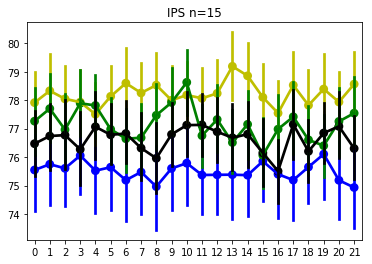

['DLPFC_0', 'DLPFC_100', 'DLPFC_200', 'DLPFC_800']


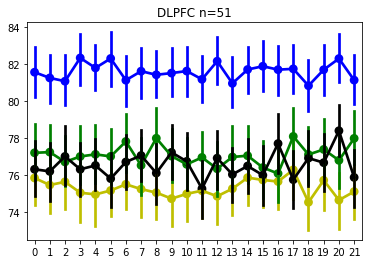

In [9]:
## If I want one line for each neuron. Example of one neuron of IPS and one of PFC

### IPS
Conditions_titles = ['LIP_0', 'LIP_100', 'LIP_200', 'LIP_800']
Colors=['b', 'y', 'g', 'k']
print(Conditions_titles)

N='15'

plt.figure()
for i in range(0,4):
    sns.pointplot(data=conditions_dictionaries[i][N], color=Colors[i], label=Conditions_titles[i], legend=True)

#
plt.title('IPS n=' + N)
plt.show()
    
    
    
Conditions_titles = ['DLPFC_0', 'DLPFC_100', 'DLPFC_200', 'DLPFC_800']
Colors=['b', 'y', 'g', 'k']
print(Conditions_titles)

N='51'

plt.figure()
for idx, cond in enumerate(range(4,8)):
    sns.pointplot(data=conditions_dictionaries[cond][N], color=Colors[idx], label=Conditions_titles[idx], legend=True)

#
plt.title('DLPFC n=' + N)
plt.show()